# Demo VirtualHome

This is a demo of how to run VirtualHome UnitySimulator. The demo will walk though how to start an environment and visualize it, how to prepare it to perform activities and finally how to perform activities in them.

In [1]:
%matplotlib notebook
import IPython.display
from utils_demo import *
import display_graph

# Starting communication

The first step is to start a communication with the simulator. Make sure before you run this that you have downloaded the simulator. You will be interacting with the simulator with the communication `comm` created here

In [2]:
comm = setup()

# Starting and Visualizing Scenes

After initalizing the simulation. We can interact with the environments provided in VirtualHome. The simulator is composed of 7 apartments, which can be seen here.

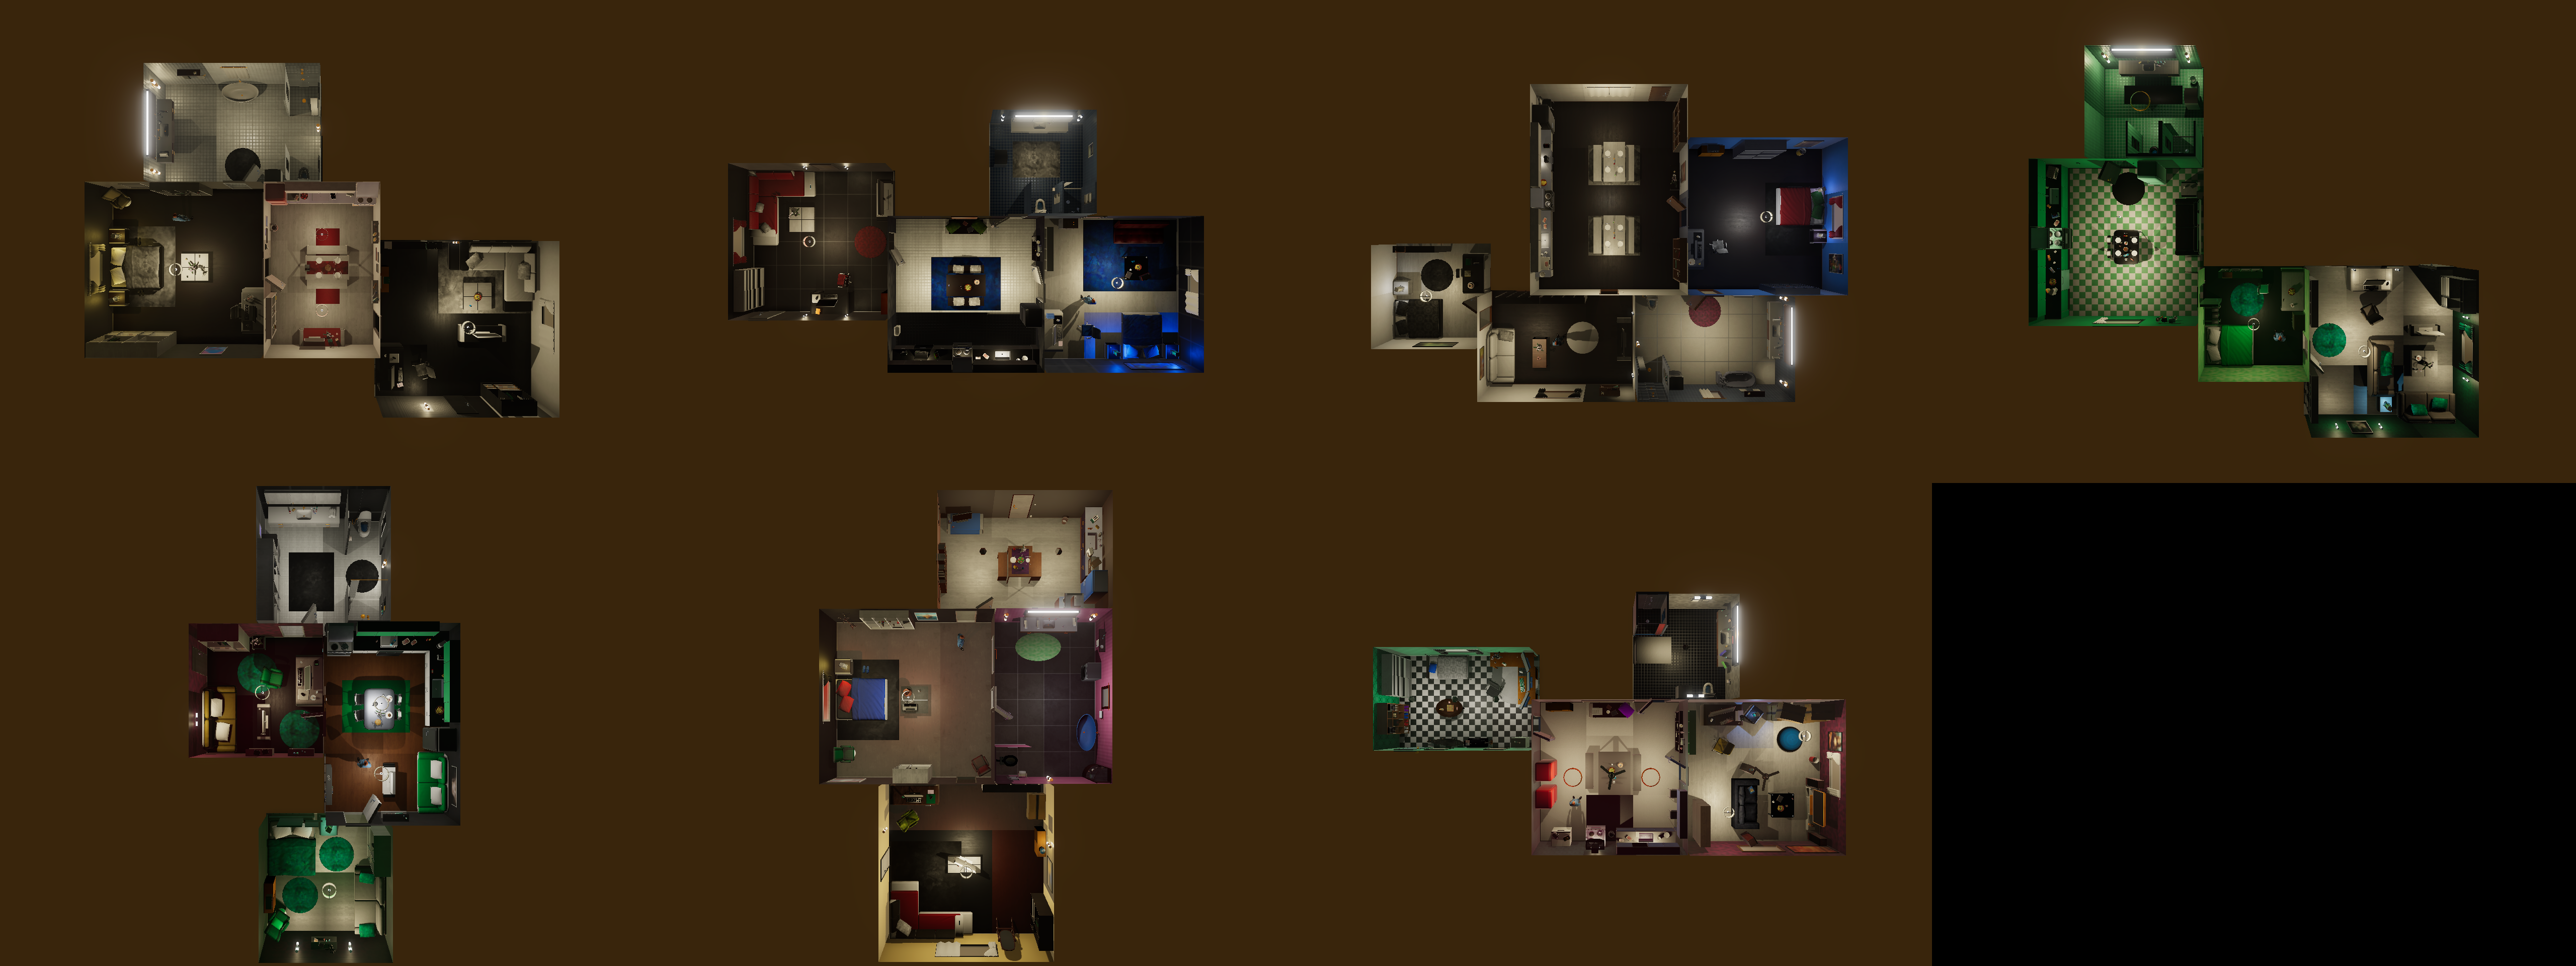

In [3]:
img = get_img_apts()
IPython.display.display(img)

## Scene start and display

We will start scene number 4 and start visualizing it. We start it by calling reset. Scenes are numbered from 0 to 6.

In [4]:
comm.reset(4)

True

Each scene has multiple cameras, we will take screenshots for some of the cameras in this scene, specified by indices.

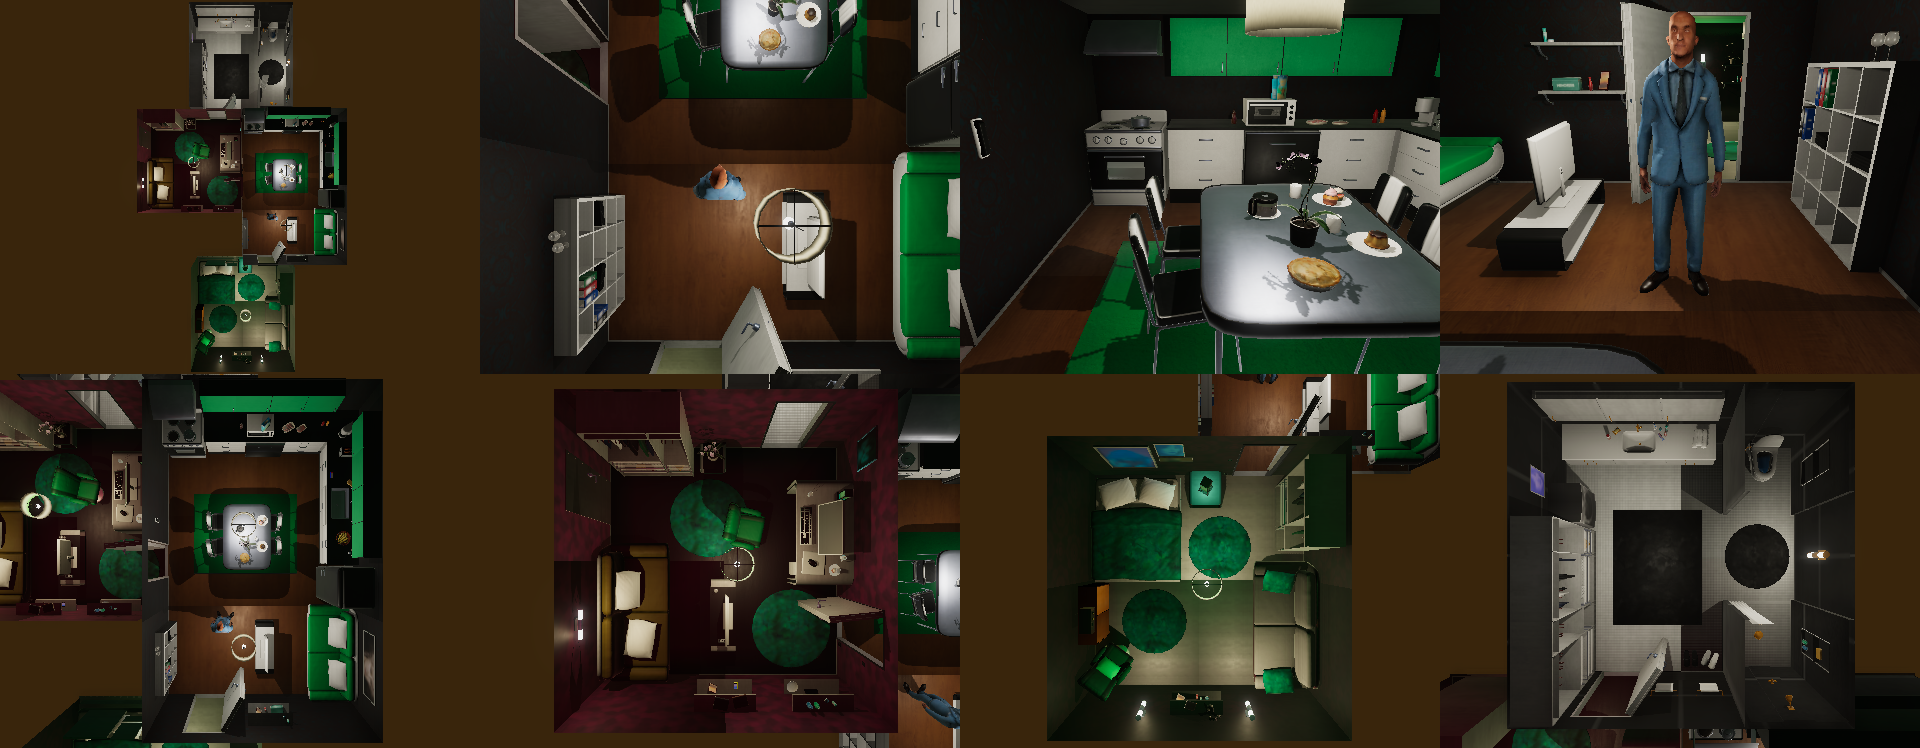

In [5]:
indices = [-7, -6, -5, -1, -10, -11, -9, -8]
img_final = display_scene_cameras(comm, indices, nrows=2)
IPython.display.display(img_final)

## VirtualHome supports multiple modalities

The cameras can also display other modalities, such as semantic segmentation, depth, instance segmentation or optical flow when playing videos. We will display a few of those here.

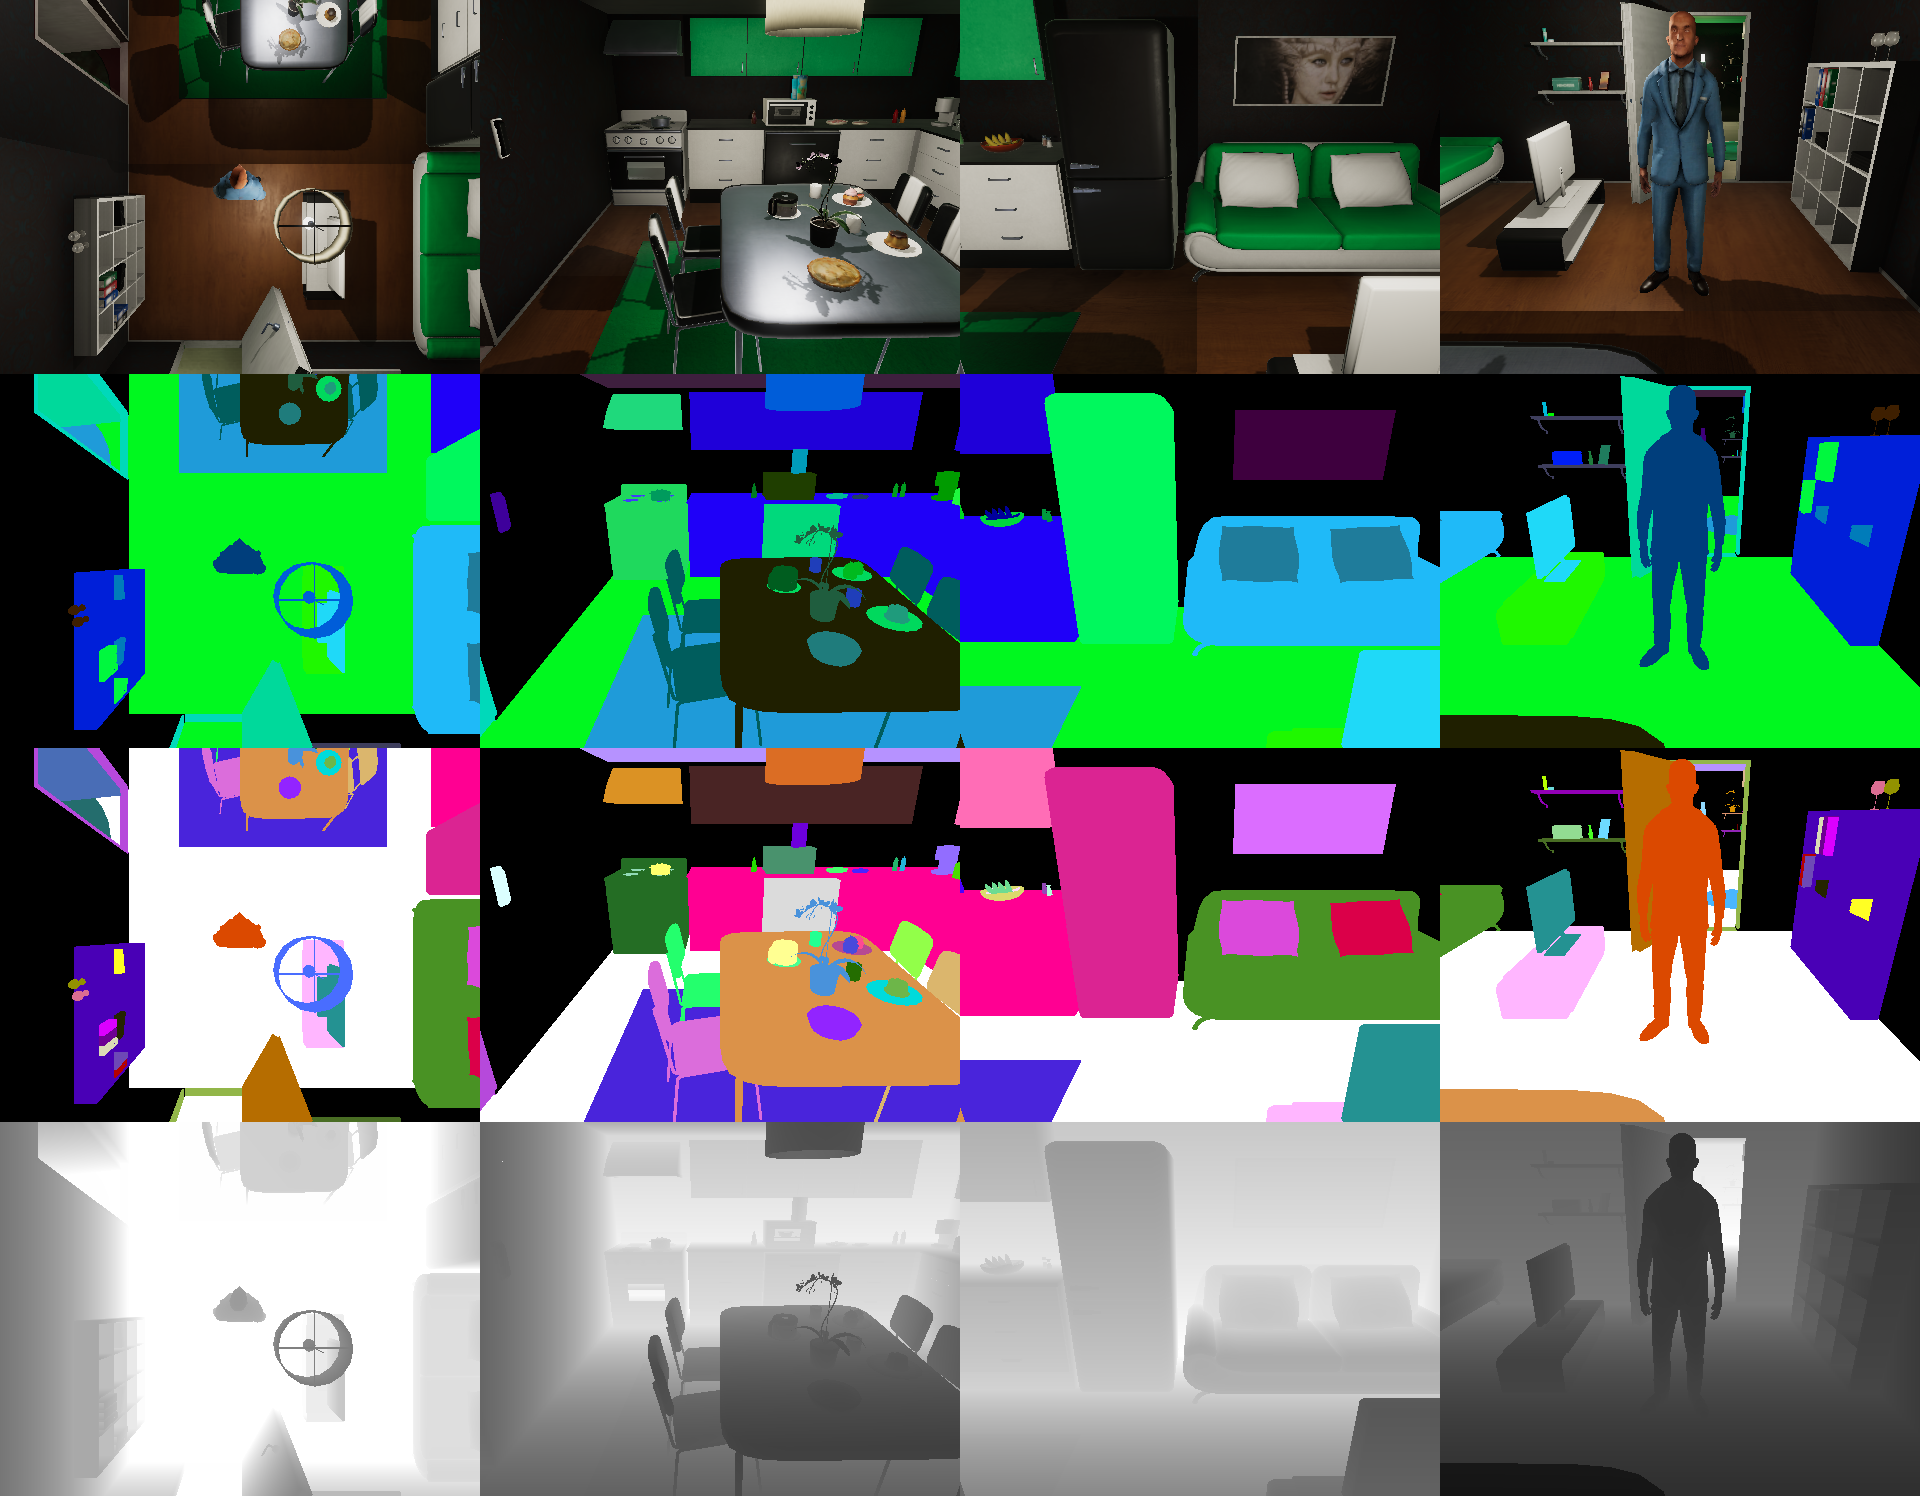

In [6]:
indices = [-6, -5, -4, -1]
img_final = display_scene_modalities(
    comm, 
    indices, 
    modalities=['normal', 'seg_class', 'seg_inst', 'depth'], nrows=4)
IPython.display.display(img_final)

## Visualizing the scene as a graph

Each scene in VirtualHome can be visualized as a graph, allowing to query the objects appearing, and their relationships. We start by obtaining the graph from the current scene.

In [7]:
s, graph = comm.environment_graph()

The graph is a dictionary with `nodes` and `edges`. Each node corresponds to an object and contains information such as.
- class_name: the object_name
- states: in which state the object is
- id: a number you can use to perform actions over the object 

Let's print one of the nodes, to see more of the information

In [8]:
graph['nodes'][140]

{'id': 141,
 'category': 'Appliances',
 'class_name': 'fridge',
 'prefab_name': 'PRE_APP_Fridge_01_04',
 'bounding_box': {'center': [7.07990456, 1.06300008, -3.06112313],
  'size': [0.711999357, 2.12600017, 0.8900006]},
 'properties': ['CAN_OPEN', 'CONTAINERS', 'HAS_PLUG'],
 'states': ['CLOSED']}

The edges connect object ids with spatial relationships, such as `INSIDE`, `ON`, `CLOSE`. You can check more of them in the `simulation` folder.

In [9]:
graph['edges'][:5]

[{'from_id': 2, 'to_id': 1, 'relation_type': 'INSIDE'},
 {'from_id': 3, 'to_id': 1, 'relation_type': 'INSIDE'},
 {'from_id': 4, 'to_id': 1, 'relation_type': 'INSIDE'},
 {'from_id': 5, 'to_id': 1, 'relation_type': 'INSIDE'},
 {'from_id': 6, 'to_id': 1, 'relation_type': 'INSIDE'}]

The graph also contains bounding box and center information, which may be useful to reason about the environment layout.

<IPython.core.display.Javascript object>


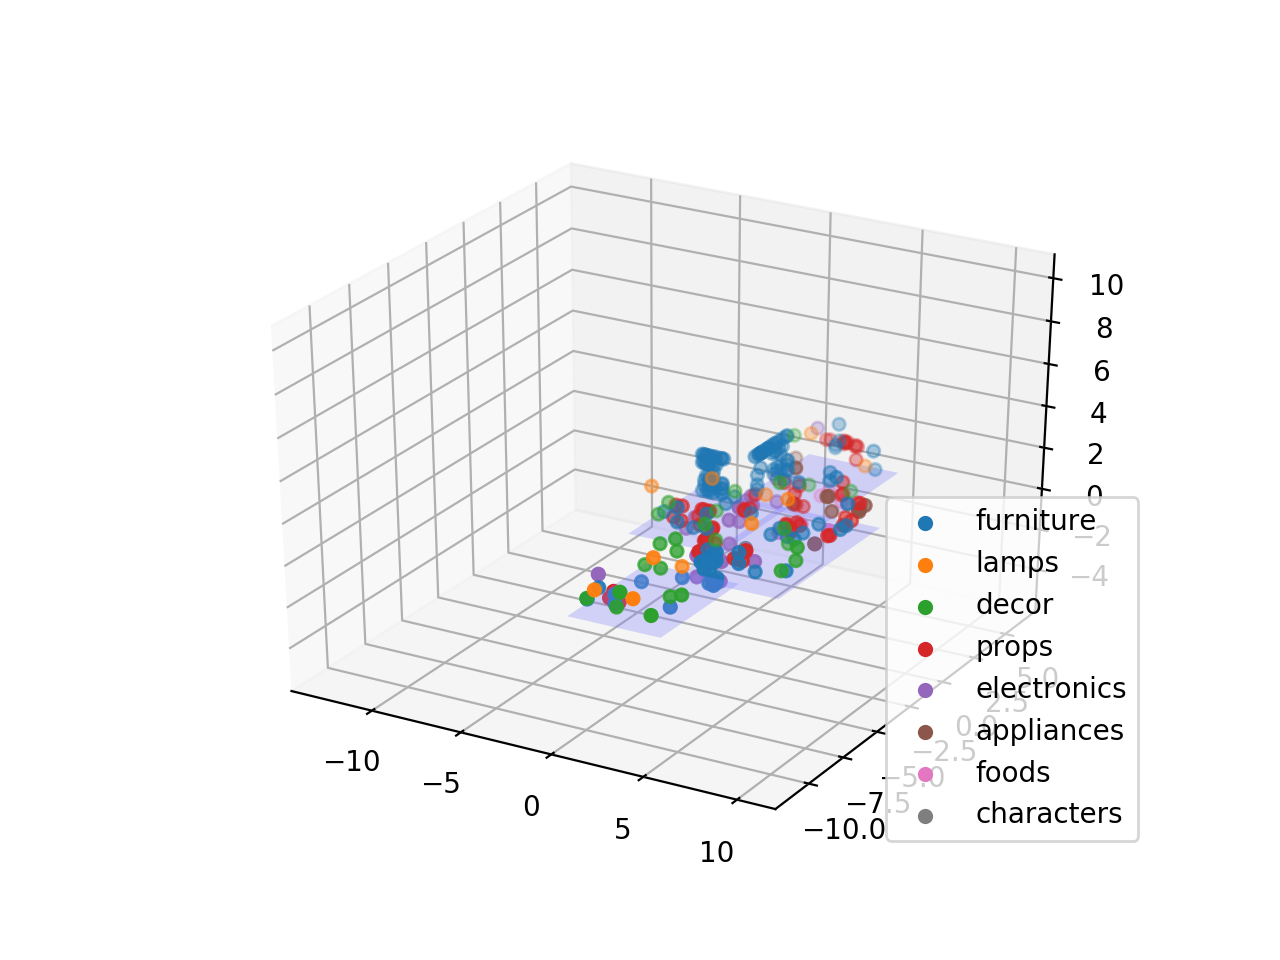

In [10]:
display_graph.display(graph)

# Modifying your environment and preparing for activities

In the previous section we viewed how to read and visualize the environment. Now we are interested in modifying the environment to perform activities in them. 

## Get default environment

All the environments have a default setting. We can go to this setting by calling reset()

In [11]:
comm.reset()

True

## Adding Objects

We will start by adding objects to interact with in the environments. We can start by adding a cat in the environment.

### Adding a cat

We first want to make sure that the cat will be added in the current environment. Let's say that we want to add it in one of the sofas.

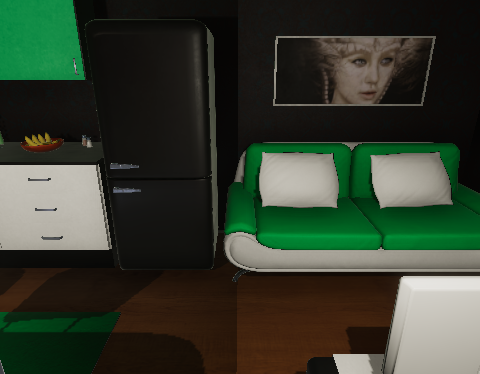

In [12]:
imgs_prev = get_scene_cameras(comm, [-4])
display_grid_img(imgs_prev, nrows=1)

We start by reading the graph and looking for one of the sodas in the scene.

In [13]:
success, graph = comm.environment_graph();
sofa = find_nodes(graph, class_name='sofa')[-2]
print(sofa)

{'id': 131, 'category': 'Furniture', 'class_name': 'sofa', 'prefab_name': 'PRE_FUR_Sofa_02_03_02_01', 'bounding_box': {'center': [6.89529371, 0.5715897, -4.879], 'size': [0.9469976, 0.885002553, 2.155935]}, 'properties': ['SITTABLE', 'LIEABLE'], 'states': []}


We now add one node with id `1000` of type cat, and an edge between the sofa node and the cat, specifying that the cat should be on the sofa.

In [14]:
add_node(graph, {'class_name': 'cat', 
                   'category': 'Animals', 
                   'id': 1000, 
                   'properties': [], 
                   'states': []})
add_edge(graph, 1000, 'ON', sofa['id'])

#### Update environment

The graph is now updated, but now we have to call the simulator so that the environment gets updated with the graph. Let's do it.

In [15]:
success, message = comm.expand_scene(graph)

The environment has now a new cat, being placed on top of the sofa.

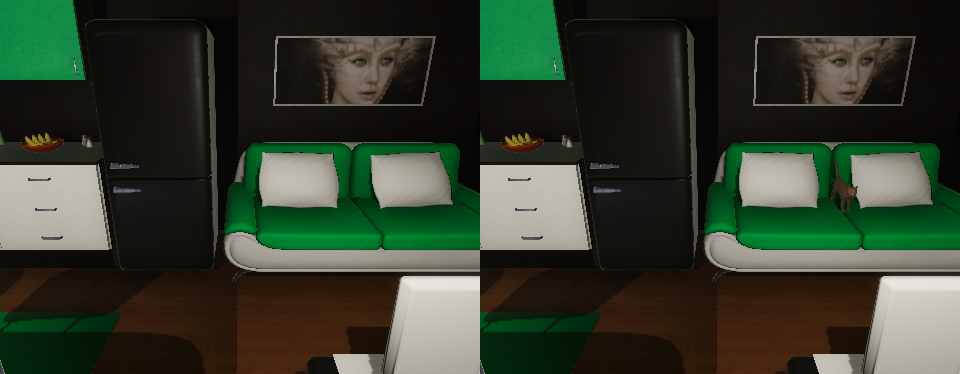

In [16]:
imgs_final = get_scene_cameras(comm, [-4])
display_grid_img(imgs_prev+imgs_final, nrows=1)

In [17]:
imgs_prev = imgs_final

### Opening fridge

We may not want to add any new object, but just to change the state of the current objects. We can do this very similarly, by changing the environment graph. Let's say we want to open the fridge.

We read again the graph

In [18]:
success, graph = comm.environment_graph();

We find the node `fridge` and change its `states` to open. 

In [19]:
fridge = find_nodes(graph, class_name='fridge')[0]

In [20]:
fridge['states'] = ['OPEN']

We finally expand the graph, as we did before.

In [21]:
success = comm.expand_scene(graph)

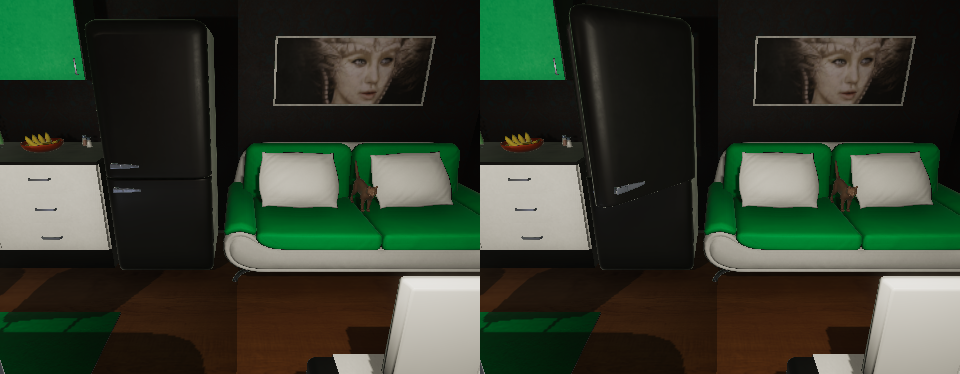

In [22]:
imgs_final = get_scene_cameras(comm, [-4])
display_grid_img(imgs_prev+imgs_final, nrows=1)

### Applicances

We will use the same method as before to change the state of some appliances. Again just by modifying the state of the graph.

We take a picture of the apartment to see how it looks before doing any change

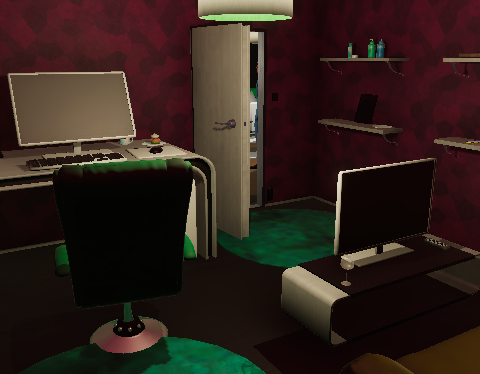

In [23]:
indices = [0]
imgs_prev = get_scene_cameras(comm, indices)
display_grid_img(imgs_prev, nrows=1)

We now get the graph of the environment, and select a TV and a light

In [24]:
success, graph = comm.environment_graph()
tv_node = [x for x in graph['nodes'] if x['class_name'] == 'tv'][0]
light_node = [x for x in graph['nodes'] if x['class_name'] == 'lightswitch'][0]

We change the state and modify the scene with the new graph.

In [25]:
tv_node['states'] = ['ON']
light_node['states'] = ['OFF']
_ = comm.expand_scene(graph)
last_graph = graph

We visualize the final scene

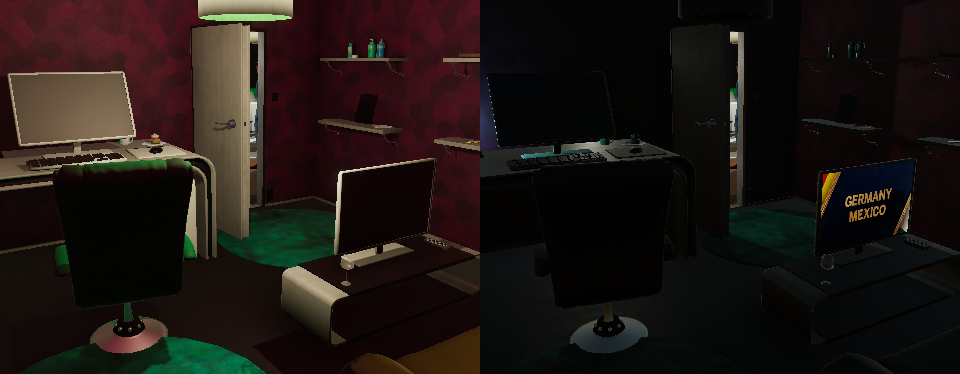

In [26]:
imgs_final = get_scene_cameras(comm, indices)
display_grid_img(imgs_prev+imgs_final, nrows=1)


# Generating Scripts

We now can start scenes, visualize them and modify them. The last step is to perform activities in them. We do this by defining scripts: Lists of instructions that will be executed in sequence. Each instruction contains an action, an object, and an id. The id should match with the `id` of each of the nodes in the environment graph.

This is the list of actions implemented currently
- Open
- Close
- SwitchOn
- SwitchOff
- PutBack
- PutIn
- Drink
- Talk
- Text
- Grab
- Sit
- StandUp
- Walk
- Run
- TurnTo
- PointAt
- LookAt
- Find
- Touch

## Generating the first script

Let's start by interacting witht the cat and the sofa that we set up before. The cat had id 1000. The sofa was stored in a variable `sofa` containing that node. We can query its id directly. This sequence will make the agent walk to the sofa, grab the cat and sit in the sofa.

In [27]:
script = ['[Walk] <sofa> ({})'.format(sofa['id']),
          '[Find] <cat> (1000)',
          '[Grab] <cat> (1000)',
          '[Find] <sofa> ({})'.format(sofa['id']),
          '[Sit] <sofa> ({})'.format(sofa['id'])]


We now want to execute the script in the environment. We do that through render_script. Notice that we can specify a file name, which will be used to save a video with the activity.

In [28]:
success, message = comm.render_script(script=script,
                                      processing_time_limit=60,
                                      find_solution=False,
                                      image_width=320,
                                      image_height=240,
                                      image_synthesis=['normal'],
                                      file_name_prefix='relax')



In [29]:
display_vid('./Output/relax/Action_normal.mp4')

Other paramters to render_script are:
- script: a list of script lines
- randomize_execution: randomly choose elements
- random_seed: random seed to use when randomizing execution, -1 means that the seed is not set
- find_solution: find solution (True) or use graph ids to determine object instances (False)
- processing_time_limit: time limit for finding a solution
- skip_execution: skip rendering, only check if a solution exists
- output_folder: folder to output renderings, default is Output/
- file_name_prefix: prefix of created files (screenshots are put to output_folder/file_name_prefix/)
- frame_rate: frame rate
- capture_screenshot: save screenshots
- image_synthesis: save depth, segmentation, flow images
- save_pose_data: save pose data
- save_scene_states: save scene states
- character_resource: path to character resource to be used
- camera_mode: automatic (AUTO), first person (FIRST_PERSON), top (PERSON_TOP), front person view (PERSON_FRONT)

## Generating a script without a video

In some occasions you may not be interested in generating a full video for the script, for example if you want to do RL. You can run the script withtout rendering a video by setting image_synthesis to empty. This will execute the script much more quickly

Restart the previous graph

In [30]:
comm.reset()
_, _ = comm.expand_scene(last_graph)

Run with `image_synthesis=[]`

In [31]:
success, message = comm.render_script(script=script,
                                      processing_time_limit=60,
                                      find_solution=False,
                                      image_synthesis=[])

## Generating from multiple views

We can chose which camera to use while rendering the videos. This is done through the flag `CAMERA_MODE`.

In [32]:
comm.reset()
_, _ = comm.expand_scene(last_graph)
success, message = comm.render_script(script=script,
                                      processing_time_limit=60,
                                      find_solution=False,
                                      image_synthesis=[],
                                      camera_mode='FIRST_PERSON')

## Generating underspecified videos

If we do not care which objects the simulator should interact with, we can also let it decide. If we use the flag `find_solution=True` we can start enumerating objects by `1` instead of following the graph ids. Unity will try to find a solution. Note that if we want to interact with 2 objects of the same kind, they will need to have different ids (i.e. 1 and 2)

In [33]:
comm.reset(6)

True

In [34]:
script = ['[Walk] <milk> (1)',
          '[Grab] <milk> (1)',
          '[Walk] <microwave> (1)',
          '[Open] <microwave> (1)',
          '[PutIn] <milk> (1) <microwave> (1)',
          '[Close] <microwave> (1)',
          '[SwitchOn] <microwave> (1)']
          
success, message = comm.render_script(script=script, 
                                      find_solution=True,
                                      processing_time_limit=80,
                                      frame_rate=15,
                                      image_width=512, image_height=320,
                                      file_name_prefix='milk',
                                      camera_mode='FIRST_PERSON')

In [ ]:
display_vid('./Output/milk/Action_normal.mp4')